# Stock market clustering using CUML and Kmeans.



Here is the [dataset](https://www.kaggle.com/rohitjain454/all-stocks-5yr)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/all-stocks-5yr/all_stocks_5yr.csv


In [2]:
import sys
!cp ../input/rapids/rapids.21.06 /opt/conda/envs/rapids.tar.gz
!cd /opt/conda/envs/ && tar -xzvf rapids.tar.gz > /dev/null
sys.path = ["/opt/conda/envs/rapids/lib/python3.7/site-packages"] + sys.path
sys.path = ["/opt/conda/envs/rapids/lib/python3.7"] + sys.path
sys.path = ["/opt/conda/envs/rapids/lib"] + sys.path 
!cp /opt/conda/envs/rapids/lib/libxgboost.so /opt/conda/lib/

cp: cannot stat '../input/rapids/rapids.21.06': No such file or directory
tar (child): rapids.tar.gz: Cannot open: No such file or directory
tar (child): Error is not recoverable: exiting now
tar: Child returned status 2
tar: Error is not recoverable: exiting now
cp: cannot stat '/opt/conda/envs/rapids/lib/libxgboost.so': No such file or directory


In [3]:
import cuml
import cudf

In [4]:
# Both import methods supported
from cuml import KMeans
from cuml.cluster import KMeans



In [5]:
import numpy as np
import os
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import pandas as pd
from pandas import read_csv

In [6]:
#Read the data
filename = '../input/all-stocks-5yr/all_stocks_5yr.csv'
stock = read_csv(filename)
print("***Structure of data with all its features***")
stock.head()

***Structure of data with all its features***


,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


In [7]:

df = cudf.read_csv(filename)


In [8]:
df.tail(3)

,date,open,high,low,close,volume,Name
619037,2018-02-05,76.64,76.92,73.18,73.83,2962031,ZTS
619038,2018-02-06,72.74,74.56,72.13,73.27,4924323,ZTS
619039,2018-02-07,72.70,75.00,72.69,73.86,4534912,ZTS


In [9]:
df.isnull().sum()

date       0
open      11
high       8
low        8
close      0
volume     0
Name       0
dtype: uint64

In [10]:
df = df.dropna()

In [11]:
df.isnull().sum()

date      0
open      0
high      0
low       0
close     0
volume    0
Name      0
dtype: uint64

There is a positive correlation between the open and close amount

<AxesSubplot:xlabel='open', ylabel='close'>

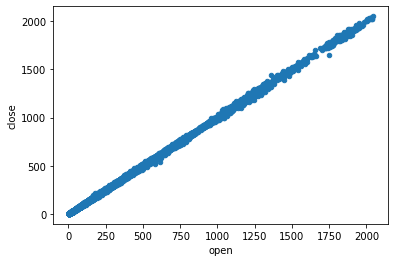

In [12]:
#Copy dataset from GPU memory to host memory and plot the dataset
df.to_pandas().plot(kind='scatter', x='open', y='close', cmap=('rainbow'), sharex=True)

In [13]:
x_train = df.drop(['date', 'Name'], axis = 1)

In [14]:
# Feature Scaling using gpu matrix 
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
df3 = sc.fit_transform(x_train.as_gpu_matrix())

In [15]:
#pca to reduce the dimension of the data

from sklearn.decomposition import PCA 
pca = PCA(2)  
projected = pca.fit_transform(df3)
print(df3.shape)
print(projected.shape)

(619029, 5)
(619029, 2)


find k using elbow method

In [16]:
def kmean_score(nclust):
    km = KMeans(n_clusters=nclust)
    km.fit(projected)
    rss = -km.score(projected)
    return rss

In [17]:
scores = [kmean_score(i) for i in range(1, 8)]

Text(0.5, 1.0, 'RSS versus K')

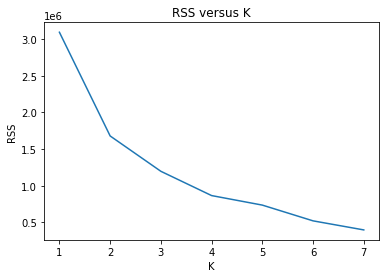

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(1, 8), scores)
plt.xlabel('K')
plt.ylabel('RSS')
plt.title('RSS versus K')

In [19]:
#fit and predict model

from cuml.cluster import KMeans as KMeans

kmeans = KMeans(n_clusters=3, max_iter=300, init='k-means||')

kme = kmeans.fit_predict(projected)


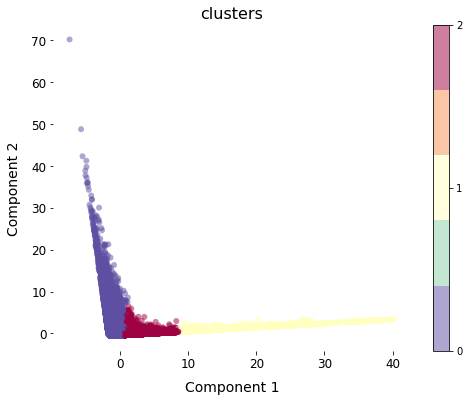

<Figure size 432x288 with 0 Axes>

In [20]:
#plot clusters


fig, ax = plt.subplots(figsize = (8, 6))

plt.scatter(projected[:, 0], projected[:, 1],
            c=kme, 
            edgecolor="none", 
            cmap=plt.cm.get_cmap("Spectral_r", 5),
            alpha=0.5)
        
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["bottom"].set_visible(False)
plt.gca().spines["left"].set_visible(False)

plt.xticks(size=12)
plt.yticks(size=12)

plt.xlabel("Component 1", size = 14, labelpad=10)
plt.ylabel("Component 2", size = 14, labelpad=10)

plt.title('clusters', size=16)


plt.colorbar(ticks=[0, 1, 2, 3, 4]);

plt.show()
plt.savefig('cluster.png')

add k means label to the dataframe

In [21]:
results_df = df.copy()

results_df['predicted'] = kmeans.labels_

results_df.tail(1005)

,date,open,high,low,close,volume,Name,predicted
618035,2014-02-12,29.20,30.1325,29.13,30.00,14394220,ZTS,0
618036,2014-02-13,29.93,30.1700,29.56,29.67,7891632,ZTS,0
618037,2014-02-14,29.66,30.0000,29.55,29.88,5579063,ZTS,0
618038,2014-02-18,29.91,30.5900,29.88,30.27,6087798,ZTS,0
618039,2014-02-19,30.04,30.1600,29.63,29.75,6169876,ZTS,0
...,...,...,...,...,...,...,...,...
619035,2018-02-01,76.84,78.2700,76.69,77.82,2982259,ZTS,0
619036,2018-02-02,77.53,78.1200,76.73,76.78,2595187,ZTS,0
619037,2018-02-05,76.64,76.9200,73.18,73.83,2962031,ZTS,0
619038,2018-02-06,72.74,74.5600,72.13,73.27,4924323,ZTS,0


In [22]:
results_df['predicted'].value_counts()

0    516756
2     96386
1      5887
Name: predicted, dtype: int32

In [23]:
#evaluation metrics

from cuml.metrics import adjusted_rand_score

score = adjusted_rand_score(labels_true=results_df['predicted'], 
                            labels_pred=kmeans.labels_)


score

1.0

In [24]:
results_df[['Name', 'predicted']]

,Name,predicted
0,AAL,0
1,AAL,0
2,AAL,0
3,AAL,0
4,AAL,0
...,...,...
619035,ZTS,0
619036,ZTS,0
619037,ZTS,0
619038,ZTS,0


## Future work:
- Label the clusters
- Behaviour test and setup model explanability
- export and deploy the model using fast or flask api